**Описание проекта**

Вы — специалист по Data Science в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

Идея решения задачи от заказчика:

Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)

Для модели выбрать тип виновника — только машина (car).

Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).

Для моделирования ограничиться данными за 2012 год — они самые свежие.

Обязательное условие — учесть фактор возраста автомобиля.

На основе модели исследовать основные факторы ДТП.

Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:

Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?

Какие ещё факторы нужно учесть?

Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы.

**ОГЛАВЛЕНИЕ**

<a href='#1'>Подключитесь к базе. Загрузите таблицы sql</a>

<a href='#2'>Проведите первичное исследование таблиц</a>

<a href='#3'>Проведите статистический анализ факторов ДТП</a>

<a href='#4'>Создайте модель для оценки водительского риска</a>

<a href='#5'>Исследовательский анализ данных</a>

<a href='#6'>Корреляционный анализ</a>

<a href='#7'>Обучение модели</a>

<a href='#8'>Проведите анализ важности факторов ДТП</a>

<a href='#9'>Выводы</a>

In [1]:
%reload_ext autoreload

In [2]:
!pip install sqlalchemy -q

!pip install --upgrade ipython-sql sqlalchemy -q

!pip install --upgrade pandas -q

!pip install phik -q

!pip install scikit-learn==1.1.3 -q

!pip install shap -q

!pip install catboost -q

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt

from phik.report import correlation_report, plot_correlation_matrix


from scipy import stats as st
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from catboost import cv, Pool

from sklearn.linear_model import(
    Ridge,
    RidgeClassifier,
    LinearRegression,
    LogisticRegression,
) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import (
    mean_squared_error,
    roc_curve,
    roc_auc_score,
    f1_score,
    recall_score,
    make_scorer
)

from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             mean_absolute_error, 
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             r2_score
                            )
    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

import shap
from sklearn.feature_selection import SelectKBest, f_classif

from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

import datetime
from datetime import date
from datetime import time

from sqlalchemy import create_engine

RANDOM_STATE = 42
TEST_SIZE = 0.25

<a id='1'></a>
## Подключитесь к базе. Загрузите таблицы sql

In [4]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [5]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [6]:
engine = create_engine(connection_string)

<a id='2'></a>
## Проведите первичное исследование таблиц

In [7]:
query_01 = '''
SELECT table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE';
'''

In [8]:
dataname_df = pd.read_sql_query(query_01, con = engine)

In [9]:
dataname_df

,table_name
0,pg_type
1,pg_foreign_table
2,pg_amop
3,pg_amproc
4,pg_language
...,...
59,pg_inherits
60,collisions
61,case_ids
62,parties


In [10]:
query_1 = '''
SELECT *
FROM collisions
LIMIT(10)
'''

In [11]:
collisions_df = pd.read_sql_query(query_1, con = engine)

In [12]:
collisions_df.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [13]:
query_2 = '''
SELECT *
FROM parties
LIMIT(10)
'''

In [14]:
parties_df = pd.read_sql_query(query_2, con = engine)

In [15]:
parties_df.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [16]:
query_3 = '''
SELECT *
FROM vehicles
LIMIT(10)
'''

In [17]:
vehicles_df = pd.read_sql_query(query_3, con = engine)

In [18]:
vehicles_df.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [19]:
query_4 = '''
SELECT *
FROM case_ids
LIMIT(10)
'''

In [20]:
case_ids_df = pd.read_sql_query(query_4, con = engine)

In [21]:
case_ids_df.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Для создания модели нам даны три таблицы с информацией об авариях, участниках аварии и автомобилях. Согласно техническому заданию, необходимо оценить риск ДТП по выбранному маршруту движения. В качестве целевой переменной предлагается использоваать переменную, принимающую два значения: виновен (1) или не виновен (0) водитель в ДТП. То есть, предсказание целевой переменной, конечно, косвенно связано с риском ДТП, однако в реальности мы будем предсказывать только вероятность виновности или не виновности в ДТП.

Анализ доступных нам параметров показывает, что большинство из них не годятся для создания модели, так как они становятся известными только после того, как авария произошла. Явно не хватает данных о водителе: возраст, пол, стаж вождения и т.д. Возможно, косвенно эта информация входит в параметр Сумма страховки. К сожалению, подробностей в техническом задании нет.

Общий ключ для связи таблиц имеется: это case_id.

<a id='3'></a>
##  Проведите статистический анализ факторов ДТП

In [22]:
query_5 = '''
SELECT CAST(DATE_TRUNC('month', collisions.collision_date) AS date),
COUNT(case_id)
FROM collisions
GROUP BY CAST(DATE_TRUNC('month', collisions.collision_date) AS date);
'''

In [23]:
month_df = pd.read_sql_query(query_5, con = engine)

In [24]:
month_df

,date_trunc,count
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916
5,2009-06-01,34202
6,2009-07-01,35161
7,2009-08-01,34508
8,2009-09-01,35555
9,2009-10-01,37835


Из запроса количества ДТП по месяцам видно, что в таблице collisions присутствуют данные с 2009 по 2013 гг., а также несколько записей для 2020 года. Видно, что данные по месяцам неполные.

Сделаем группировку по месяцу ДТП и построим распределение числа аварий от номера месяца. Возьмем только те годы, где данные полные.

In [25]:
query_6 = '''
WITH t AS (SELECT ROUND(EXTRACT(MONTH FROM CAST(DATE_TRUNC('month', collisions.collision_date) AS date))) AS month,
case_id
FROM collisions
WHERE EXTRACT(YEAR FROM CAST(DATE_TRUNC('year', collisions.collision_date) AS date)) < 2012)
SELECT t.month,
COUNT(t.case_id)
FROM t
GROUP BY t.month;
'''

In [26]:
month_num_df = pd.read_sql_query(query_6, con = engine)

In [27]:
month_num_df

,month,count
0,1.0,99880
1,2.0,98373
2,3.0,107036
3,4.0,101032
4,5.0,105148
5,6.0,99531
6,7.0,101835
7,8.0,103467
8,9.0,104649
9,10.0,111933


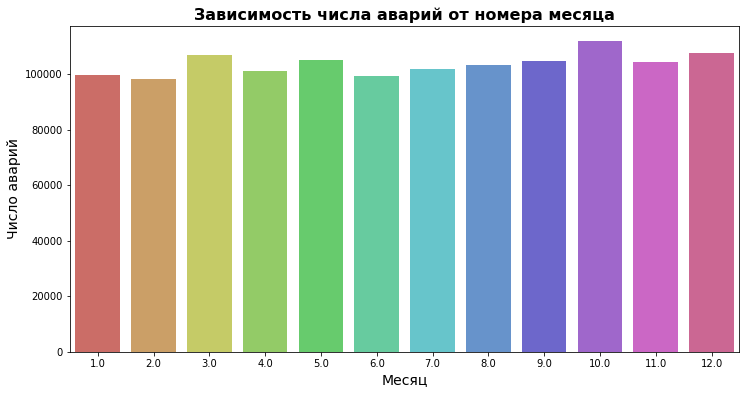

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=month_num_df, 
    x="month", 
    y="count",
    palette='hls',
)
plt.xlabel('Месяц', fontsize=14),
plt.ylabel('Число аварий', fontsize=14),
plt.title('Зависимость числа аварий от номера месяца', fontsize=16, fontweight="bold");
#plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left');

Самое большое число аварий происходит в октябре. Затем следует март и декабрь.

**Задача №1.**

**Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП. Выберите тип виновника — только машина (car). Возьмите данные только за 2012 год.**

In [29]:
query_7 = '''
WITH t AS (SELECT DISTINCT c.case_id, p.party_number,
p.party_type, c.collision_damage, c.road_surface, c.collision_date
FROM collisions AS c
INNER JOIN parties p ON c.case_id = p.case_id
WHERE p.party_type = 'car' AND EXTRACT(YEAR FROM CAST(DATE_TRUNC('year', c.collision_date) AS date))=2012)
SELECT t.collision_damage, t.road_surface
FROM t;
'''

In [30]:
damage_road_df = pd.read_sql_query(query_7, con = engine)

In [31]:
damage_road_df.head(10)

,collision_damage,road_surface
0,scratch,wet
1,scratch,wet
2,small damage,dry
3,scratch,dry
4,scratch,dry
5,small damage,dry
6,small damage,dry
7,small damage,dry
8,small damage,dry
9,small damage,dry


Сосчитаем относительное число каждого вида повреждений для каждого состояния дороги. Учтем то обстоятельство, что для каждого состояния дороги может быть собрано разное количество данных. Так, для заснеженной дороги в Калифорнии, скорее всего, будет очень мало строк в таблице, а для сухой дороги - много. 

In [32]:
damage = pd.DataFrame(columns=['wet', 'dry', 'slippery', 'snowy'])

In [33]:
damage['wet'] = damage_road_df[damage_road_df['road_surface'] == 'wet']['collision_damage'].value_counts(normalize=True)

In [34]:
damage['dry'] = damage_road_df[damage_road_df['road_surface'] == 'dry']['collision_damage'].value_counts(normalize=True)

In [35]:
damage['slippery'] = damage_road_df[damage_road_df['road_surface'] == 'slippery']['collision_damage'].value_counts(normalize=True)

In [36]:
damage['snowy'] = damage_road_df[damage_road_df['road_surface'] == 'snowy']['collision_damage'].value_counts(normalize=True)

In [37]:
damage

,wet,dry,slippery,snowy
collision_damage,,,,
small damage,0.607600,0.584019,0.606061,0.718109
scratch,0.277449,0.279380,0.222222,0.173952
middle damage,0.088944,0.104277,0.095960,0.077609
severe damage,0.017453,0.018114,0.050505,0.019625
fatal,0.008555,0.014210,0.025253,0.010705


<Figure size 864x432 with 0 Axes>

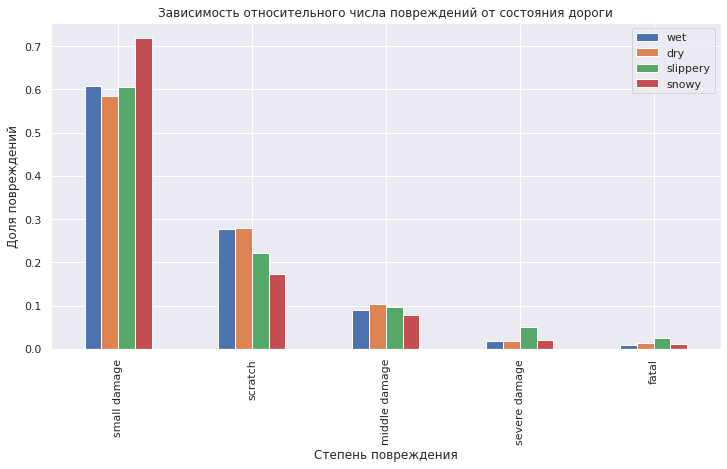

In [38]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

damage.plot(kind='bar', figsize=(12, 6))

plt.ylabel('Доля повреждений')
plt.xlabel('Степень повреждения')
plt.title('Зависимость относительного числа повреждений от состояния дороги')
plt.legend() 
plt.show();

Вероятность получения повреждений уменьшается следующим образом: легкие повреждения (максимум), царапины, средние повреждения и серьезные повреждения. Средние повреждения можно получить практически с одинаковой вероятностью на любой дороге, серьезные повреждения  - на скользкой дороге, царапины - на влажной и сухой дороге, а легкие повреждения - почему-то на заснеженной.

Теперь посмотрим на зависимость общего числа повреждений, приведенных в данных, от состояния дороги.

In [39]:
pd.pivot_table(damage_road_df,
               index=["road_surface"],
               columns=["collision_damage"],
               aggfunc=[len])

len                                                 
collision_damage fatal middle damage scratch severe damage small damage
road_surface                                                           
dry               3462         25405   68065          4413       142284
slippery             5            19      44            10          120
snowy               12            87     195            22          805
wet                224          2329    7265           457        15910

In [40]:
pivot_table_data = pd.pivot_table(damage_road_df,
               index=["road_surface"],
               columns=["collision_damage"],
               aggfunc=[len])

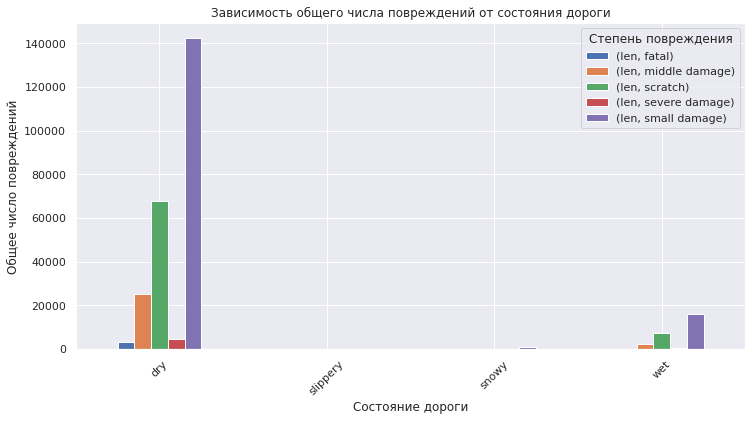

In [41]:
pivot_table_data.plot(kind='bar', figsize=(12, 6))
plt.title('Зависимость общего числа повреждений от состояния дороги')
plt.xlabel('Состояние дороги')
plt.ylabel('Общее число повреждений')
plt.xticks(rotation=45)
plt.legend(title='Степень повреждения')
plt.show()

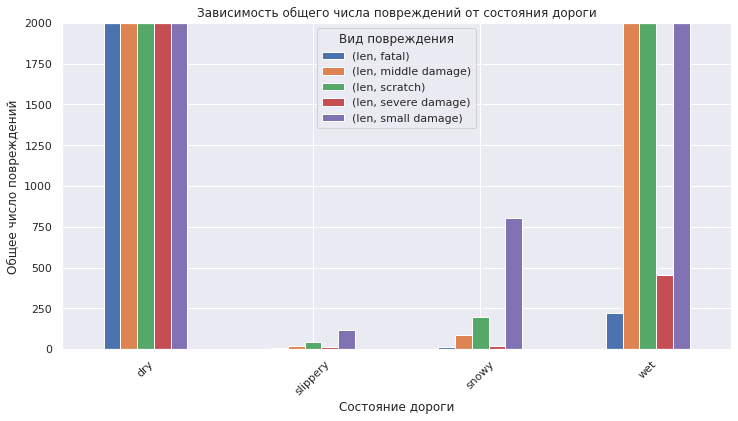

In [42]:
pivot_table_data.plot(kind='bar', figsize=(12, 6), ylim=(0, 2000))
plt.title('Зависимость общего числа повреждений от состояния дороги')
plt.xlabel('Состояние дороги')
plt.ylabel('Общее число повреждений')
plt.xticks(rotation=45)
plt.legend(title='Вид повреждения')
plt.show()

График фактически отражает количество данных, собранных для каждого состояния дороги. Больше всего данных собрано для сухой дороги.

**Задача №2.**

**Найдите самый частый тип участника ДТП (таблица parties).**

In [43]:
query_8 = '''
SELECT p.party_type,
COUNT(DISTINCT p.case_id)
FROM parties AS p
GROUP BY p.party_type;
'''

In [44]:
party_type_df = pd.read_sql_query(query_8, con = engine)

In [45]:
party_type_df.head()

,party_type,count
0,building,47748
1,car,1390168
2,other,8517
3,road bumper,138033
4,road signs,45312


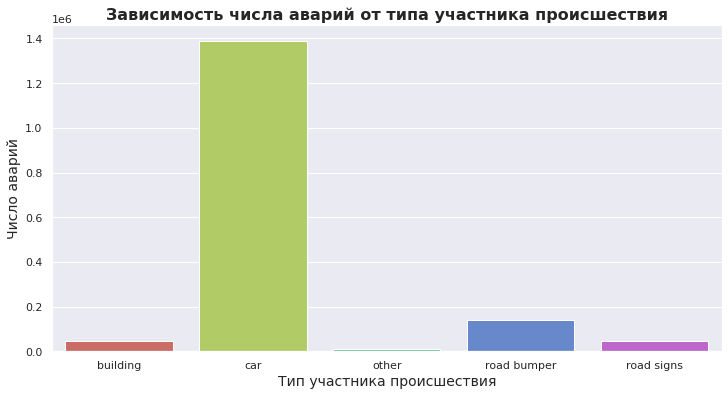

In [46]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=party_type_df, 
    x="party_type", 
    y="count",
    palette='hls',
)
plt.xlabel('Тип участника происшествия', fontsize=14),
plt.ylabel('Число аварий', fontsize=14),
plt.title('Зависимость числа аварий от типа участника происшествия', fontsize=16, fontweight="bold");

Больше всего данных представлено для типа участника проишествия - машина (car).

**Задача №3.**

**Определите, как зависит степень повреждения от среднего возраста автомобиля. Выберите тип виновника — только машина (car).**

In [47]:
query_9 = '''
WITH t AS (SELECT DISTINCT c.case_id, v.party_number,
p.party_type,
v.vehicle_age,
c.collision_damage
FROM collisions AS c
INNER JOIN parties p ON c.case_id = p.case_id
INNER JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car')
SELECT t.collision_damage, t.vehicle_age
FROM t;
'''

In [48]:
vehicle_age_df = pd.read_sql_query(query_9, con = engine)

In [49]:
vehicle_age_df.head()

,collision_damage,vehicle_age
0,small damage,3.0
1,scratch,11.0
2,scratch,10.0
3,scratch,10.0
4,small damage,9.0


In [50]:
vehicle_age_gr = vehicle_age_df.groupby(['collision_damage']).mean()

In [51]:
vehicle_age_gr

,vehicle_age
collision_damage,
fatal,6.164745
middle damage,5.315701
scratch,5.589236
severe damage,5.503124
small damage,4.281373


<Figure size 864x432 with 0 Axes>

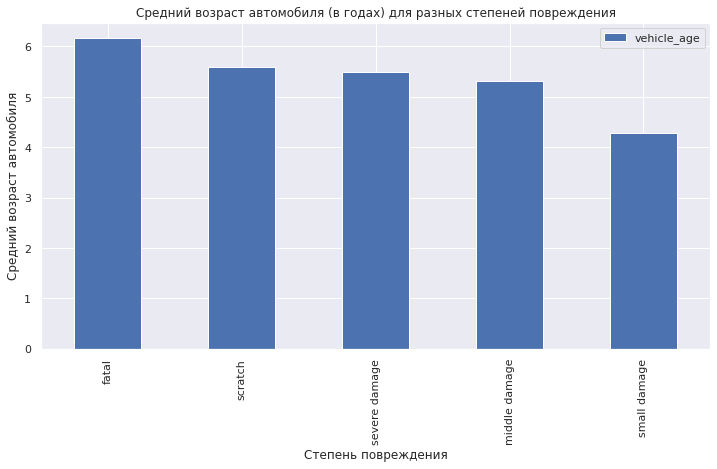

In [52]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

vehicle_age_gr.sort_values(['vehicle_age'], ascending=False).plot(kind='bar', figsize=(12, 6))

plt.ylabel('Средний возраст автомобиля')
plt.xlabel('Степень повреждения')
plt.title('Средний возраст автомобиля (в годах) для разных степеней повреждения') 
plt.show();

In [53]:
vehicle_age_df[vehicle_age_df['collision_damage'] == 'scratch']['vehicle_age'].mean()

5.589235841737781

In [54]:
vehicle_age_df[vehicle_age_df['collision_damage'] == 'small damage']['vehicle_age'].mean()

4.281373433621494

In [55]:
vehicle_age_df[vehicle_age_df['collision_damage'] == 'middle damage']['vehicle_age'].mean()

5.315700916698086

In [56]:
vehicle_age_df[vehicle_age_df['collision_damage'] == 'severe damage']['vehicle_age'].mean()

5.503123605533244

In [57]:
vehicle_age_df[vehicle_age_df['collision_damage'] == 'fatal']['vehicle_age'].mean()

6.164745354439091

In [58]:
vehicle_age_df['vehicle_age'].mean()

5.151653156025139

In [59]:
df_temp = pd.DataFrame(columns=['damage_type', 'average_age'])

In [60]:
df_temp['damage_type'] = ['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal']

In [61]:
df_temp['average_age'] = [5.59, 4.28, 5.32, 5.50, 6.16]

In [62]:
df_temp

,damage_type,average_age
0,scratch,5.59
1,small damage,4.28
2,middle damage,5.32
3,severe damage,5.50
4,fatal,6.16


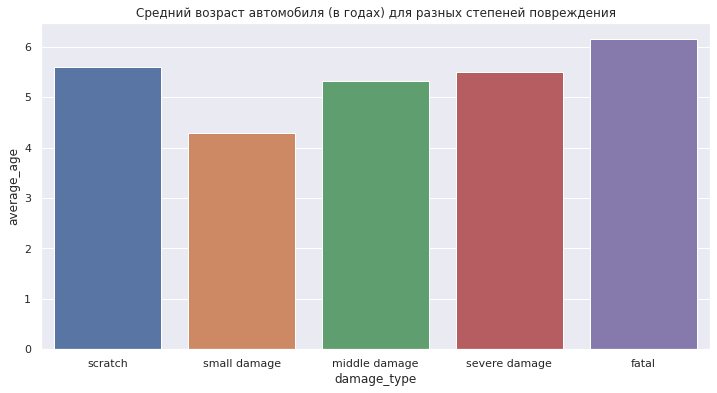

In [63]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_temp, 
    x="damage_type", 
    y="average_age", 
)
plt.title('Средний возраст автомобиля (в годах) для разных степеней повреждения');

Из гистограммы видно, что степень повреждения связана с возрастом автомобиля. Самые серьезные повреждения происходят с более возрастными автомобилями.

**Задача №4**

**Определите, как зависит степень проишесвия от числа участников.**

**Задача №5**

**Соотнесите время ДТП со следующими категориями: утро (с 6 до 12), день (с 13 до 17), вечер (с 18 до 22), ночь (с 23 до 5). Определите, как зависит число ДТП и степень повреждения автомобиля от времени суток.**

**Задача №6**

**Соотнесите время ДТП со следующими категориями: утро (с 6 до 12), день (с 13 до 17), вечер (с 18 до 22), ночь (с 23 до 5). Определите, как зависит трезвость участника от времени суток.**

<a id='4'></a>
## Создайте модель для оценки водительского риска

**Для модели берем следующие признаки:**

COLLISION_DATE берем только день недели, хотя месяц был бы лучше. Но данные за 2012 год неполные по месяцам.

WEATHER_1, ROAD_SURFACE скорее всего сильно не поменяется за время поездки.

COUNTY_CITY_LOCATION, COUNTY_LOCATION, DIRECTION относятся к местоположению и общему направлению движения. Могут поменяться, но с меньшей вероятностью, чем другие признаки.

road_condition_1 Тоже может поменяться, но с меньшей вероятностью, особенно в Калифорнии.

AT_FAULT – целевой признак.

INSURANCE_PREMIUM, CELLPHONE_IN_USE, VEHICLE_TYPE, VEHICLE_TRANSMISSION, VEHICLE_AGE известно в начале поездки.


**Не берем:**

COLLISION_TIME так как это время аварии. Выехать можно утром, а попасть в аварию вечером.

INTERSECTION заранее не знаем, где произойдет авария.

COLLISION_DAMAGE, PRIMARY_COLL_FACTOR, DISTANCE, LOCATION_TYPE, PARTY_COUNT, PCF_VIOLATION_CATEGORY, TYPE_OF_COLLISION, MOTOR_VEHICLE_INVOLVED_WITH, PARTY_NUMBER, PARTY_TYPE заранее не известно.

LIGHTING может поменяться за поездку (днем одно освещение, вечером – другое).

PARTY_DRUG_PHYSICAL пока нет оборудования, но в будущем обязательно берем.

PARTY_SOBRIETY для этого признака оборудование уже разработано и стоит копейки по сравнению с ущербом ДТП. В будущем обязательно учитываем.

In [64]:
query_10 = '''
WITH t AS (SELECT DISTINCT c.case_id, p.party_number,
c.collision_damage,
c.COLLISION_DATE,
c.weather_1,
c.COUNTY_CITY_LOCATION,
c.COUNTY_LOCATION,
c.direction,
c.road_condition_1,
p.party_type,
p.at_fault,
p.INSURANCE_PREMIUM,
p.CELLPHONE_IN_USE,
v.VEHICLE_TYPE,
v.VEHICLE_TRANSMISSION,
v.VEHICLE_AGE
FROM collisions AS c
INNER JOIN parties p ON c.case_id = p.case_id
INNER JOIN vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car' AND EXTRACT(YEAR FROM CAST(DATE_TRUNC('year', c.collision_date) AS date))=2012 AND c.collision_damage != 'scratch')
SELECT t.COLLISION_DATE,
t.weather_1,
t.COUNTY_CITY_LOCATION,
t.COUNTY_LOCATION,
t.direction,
t.at_fault,
t.INSURANCE_PREMIUM,
t.CELLPHONE_IN_USE,
t.VEHICLE_TYPE,
t.VEHICLE_TRANSMISSION,
t.VEHICLE_AGE,
t.road_condition_1
FROM t;
'''

In [65]:
data_df = pd.read_sql_query(query_10, con = engine)

In [66]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [67]:
data_info(data_df)

,collision_date,weather_1,county_city_location,county_location,direction,at_fault,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,road_condition_1
0,2012-03-30,cloudy,3712,san diego,None,0,42.0,0.0,sedan,auto,2.0,other
1,2012-04-02,clear,3404,sacramento,None,0,31.0,0.0,sedan,auto,5.0,normal
2,2012-11-13,clear,3400,sacramento,None,0,21.0,0.0,sedan,auto,1.0,normal
3,2012-09-05,clear,3607,san bernardino,east,0,31.0,0.0,sedan,auto,4.0,normal
4,2012-11-03,clear,3400,sacramento,None,0,41.0,0.0,coupe,auto,6.0,normal


,collision_date,weather_1,county_city_location,county_location,direction,at_fault,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,road_condition_1
count,56248,56080,56248,56248,43230,56248.000000,55701.000000,51777.000000,56248,55389,54554.000000,55999
unique,366,7,496,58,4,NaN,NaN,NaN,3,2,NaN,8
top,2012-03-17,clear,1942,los angeles,north,NaN,NaN,NaN,sedan,manual,NaN,normal
freq,571,45092,6931,16236,12129,NaN,NaN,NaN,37180,29318,NaN,54066
mean,NaN,NaN,NaN,NaN,NaN,0.504427,37.607170,0.020357,NaN,NaN,4.856472,NaN
std,NaN,NaN,NaN,NaN,NaN,0.499985,16.328721,0.141218,NaN,NaN,3.234503,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,0.000000,24.000000,0.000000,NaN,NaN,3.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.000000,34.000000,0.000000,NaN,NaN,4.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.000000,49.000000,0.000000,NaN,NaN,7.000000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   collision_date        56248 non-null  object 
 1   weather_1             56080 non-null  object 
 2   county_city_location  56248 non-null  object 
 3   county_location       56248 non-null  object 
 4   direction             43230 non-null  object 
 5   at_fault              56248 non-null  int64  
 6   insurance_premium     55701 non-null  float64
 7   cellphone_in_use      51777 non-null  float64
 8   vehicle_type          56248 non-null  object 
 9   vehicle_transmission  55389 non-null  object 
 10  vehicle_age           54554 non-null  float64
 11  road_condition_1      55999 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 5.1+ MB


Выведем долю пропущенных значений для каждого столбца датафреймов.

In [68]:
pd.DataFrame(data_df.isna().mean()*100)

,0
collision_date,0.000000
weather_1,0.298677
county_city_location,0.000000
county_location,0.000000
direction,23.143934
at_fault,0.000000
insurance_premium,0.972479
cellphone_in_use,7.948727
vehicle_type,0.000000
vehicle_transmission,1.527165


Посмотрим, есть ли строки дубликаты в представленных данных и удалим их, еcли есть.

In [69]:
data_df.duplicated().sum()

105

In [70]:
data_df = data_df.drop_duplicates().reset_index(drop=True)

In [71]:
data_df.duplicated().sum()

0

Переведем дату, когда произошло ДТП, в формат datetime, чтобы потом взять от нее только день недели. Вероятность аварии зависит от дня недели и месяца. Месяц было бы неплохо тоже учесть, но данные за 2012 год - неполные по месяцам.

In [72]:
data_df['collision_date'] = pd.to_datetime(data_df['collision_date'], format='%Y-%m-%d')

In [73]:
data_df['collision_date'] = data_df['collision_date'].dt.weekday

Заменим NaN в vehicle_transmission, где есть пропуски (и нет значения other), на заглушку. В некоторых признаках, где это будет возможно, в дальнейшем, заменим пропуски на значение other. Остальные пропуски будем заменять в pipeline на наиболее часто встречающиеся значения.

In [74]:
data_df['vehicle_transmission'] = data_df['vehicle_transmission'].fillna('N')

In [75]:
data_info(data_df)

,collision_date,weather_1,county_city_location,county_location,direction,at_fault,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,road_condition_1
0,4,cloudy,3712,san diego,None,0,42.0,0.0,sedan,auto,2.0,other
1,0,clear,3404,sacramento,None,0,31.0,0.0,sedan,auto,5.0,normal
2,1,clear,3400,sacramento,None,0,21.0,0.0,sedan,auto,1.0,normal
3,2,clear,3607,san bernardino,east,0,31.0,0.0,sedan,auto,4.0,normal
4,5,clear,3400,sacramento,None,0,41.0,0.0,coupe,auto,6.0,normal


,collision_date,weather_1,county_city_location,county_location,direction,at_fault,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,road_condition_1
count,56143.000000,55975,56143,56143,43149,56143.000000,55599.000000,51683.000000,56143,56143,54450.000000,55895
unique,NaN,7,496,58,4,NaN,NaN,NaN,3,3,NaN,8
top,NaN,clear,1942,los angeles,north,NaN,NaN,NaN,sedan,manual,NaN,normal
freq,NaN,44999,6892,16185,12099,NaN,NaN,NaN,37122,29261,NaN,53964
mean,3.163600,NaN,NaN,NaN,NaN,0.504391,37.615713,0.020394,NaN,NaN,4.857062,NaN
std,1.969109,NaN,NaN,NaN,NaN,0.499985,16.329437,0.141344,NaN,NaN,3.235004,NaN
min,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN
25%,1.000000,NaN,NaN,NaN,NaN,0.000000,24.000000,0.000000,NaN,NaN,3.000000,NaN
50%,3.000000,NaN,NaN,NaN,NaN,1.000000,34.000000,0.000000,NaN,NaN,4.000000,NaN
75%,5.000000,NaN,NaN,NaN,NaN,1.000000,49.000000,0.000000,NaN,NaN,7.000000,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56143 entries, 0 to 56142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   collision_date        56143 non-null  int32  
 1   weather_1             55975 non-null  object 
 2   county_city_location  56143 non-null  object 
 3   county_location       56143 non-null  object 
 4   direction             43149 non-null  object 
 5   at_fault              56143 non-null  int64  
 6   insurance_premium     55599 non-null  float64
 7   cellphone_in_use      51683 non-null  float64
 8   vehicle_type          56143 non-null  object 
 9   vehicle_transmission  56143 non-null  object 
 10  vehicle_age           54450 non-null  float64
 11  road_condition_1      55895 non-null  object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 4.9+ MB


<a id='5'></a>
## Исследовательский анализ данных

Посмотрим на распределение числа ДТП в зависимости от дня недели поездки. 

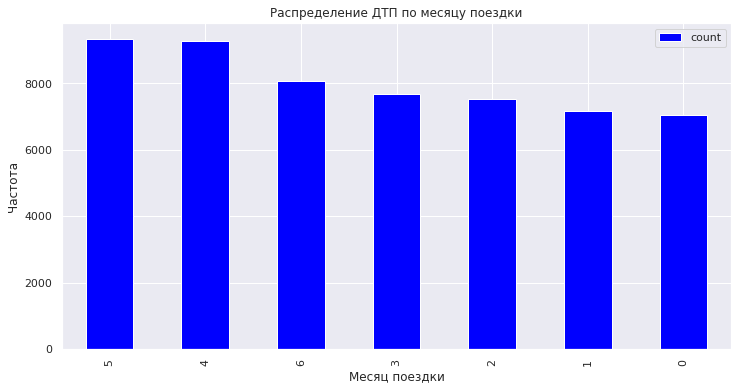

In [76]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

data_df['collision_date'].value_counts().plot(kind='bar', color="blue")

plt.ylabel('Частота')
plt.xlabel('Месяц поездки')
plt.title('Распределение ДТП по месяцу поездки')
plt.legend() 
plt.show()

Больше всего ДТП происходит в субботу и пятницу.

In [77]:
data_df['weather_1'].unique()

array(['cloudy', 'clear', 'fog', 'other', 'raining', None, 'wind',
       'snowing'], dtype=object)

In [78]:
data_df['weather_1'] = data_df['weather_1'].fillna('other')

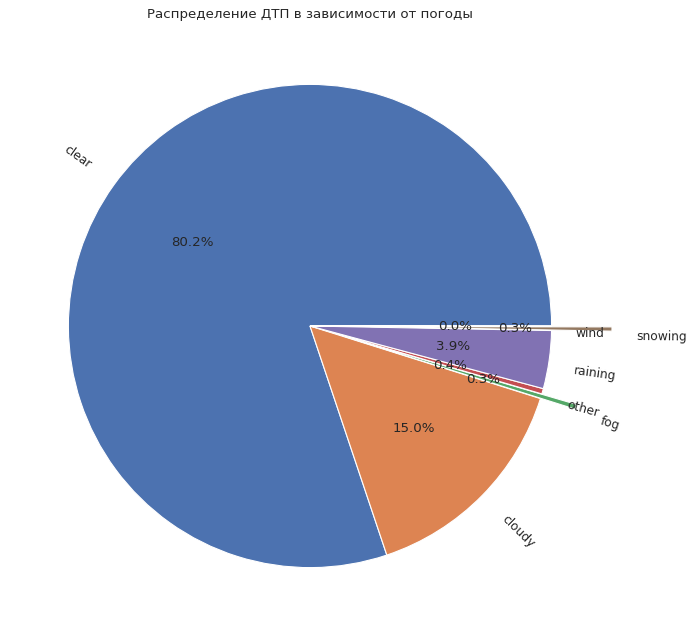

In [79]:
n1 = data_df[data_df['weather_1'] == 'clear']['at_fault'].count()
n2 = data_df[data_df['weather_1'] == 'cloudy']['at_fault'].count()
n3 = data_df[data_df['weather_1'] == 'fog']['at_fault'].count()
n4 = data_df[data_df['weather_1'] == 'other']['at_fault'].count()
n5 = data_df[data_df['weather_1'] == 'raining']['at_fault'].count()
n6 = data_df[data_df['weather_1'] == 'snowing']['at_fault'].count()
n7 = data_df[data_df['weather_1'] == 'wind']['at_fault'].count()
explode = (0, 0, 0.15, 0, 0, 0.25, 0)
plt.figure(figsize=(12,10), dpi= 80)
plt.pie([n1, n2, n3, n4, n5, n6, n7], labels=['clear', 'cloudy', 'fog', 'other', 'raining', 'snowing', 'wind'], wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'}, autopct='%.1f%%', rotatelabels=True, explode=explode)
plt.title('Распределение ДТП в зависимости от погоды')
plt.show()

Больше всего данных о ДТП приведено для ясной, облачной и дождливой погоды.

Географическое местоположение может оказывать влияние на вероятность ДТП. Поэтому посмотрим на признаки, относящиеся к месту поездки.

In [80]:
data_df['county_city_location'].unique()

array(['3712', '3404', '3400', '3607', '4313', '1942', '1500', '3711',
       '3300', '3600', '3500', '3401', '4000', '1200', '1941', '1203',
       '0900', '1915', '3700', '1919', '3900', '3100', '3200', '1985',
       '0400', '4307', '2900', '2200', '3020', '1300', '3602', '1600',
       '3302', '5703', '5400', '3906', '4900', '3019', '5406', '4203',
       '3605', '3612', '1000', '5002', '5607', '4500', '3001', '4400',
       '3029', '2300', '1964', '2002', '1900', '1800', '0105', '1956',
       '4200', '2700', '1992', '3702', '2400', '1952', '5800', '1931',
       '3105', '0112', '3619', '1950', '1301', '3616', '4302', '1961',
       '3313', '2000', '5600', '3040', '0700', '3905', '0100', '3325',
       '1507', '1914', '1968', '1948', '3010', '3049', '3709', '3394',
       '1953', '5704', '5601', '1502', '1304', '3402', '4113', '4803',
       '0106', '5202', '3801', '1922', '3012', '3450', '3618', '3701',
       '0708', '0198', '3604', '4806', '0704', '5608', '2500', '5604',
      

county_city_location - не очень удачный признак для модели, так как у него слишком меого значений.

In [81]:
data_df['county_location'].unique()

array(['san diego', 'sacramento', 'san bernardino', 'santa clara',
       'los angeles', 'kern', 'riverside', 'san benito',
       'san luis obispo', 'humboldt', 'el dorado', 'san joaquin',
       'placer', 'plumas', 'butte', 'nevada', 'mariposa', 'orange',
       'imperial', 'kings', 'yolo', 'tulare', 'sonoma', 'santa barbara',
       'fresno', 'stanislaus', 'ventura', 'shasta', 'santa cruz',
       'mendocino', 'madera', 'lassen', 'alameda', 'monterey', 'merced',
       'yuba', 'contra costa', 'san mateo', 'solano', 'tehama',
       'san francisco', 'modoc', 'calaveras', 'amador', 'mono', 'marin',
       'tuolumne', 'sutter', 'napa', 'colusa', 'siskiyou', 'glenn',
       'inyo', 'lake', 'trinity', 'alpine', 'del norte', 'sierra'],
      dtype=object)

In [82]:
data_df['county_location'].value_counts()

county_location
los angeles        16185
orange              5352
san diego           3733
san bernardino      3644
riverside           3311
sacramento          2180
alameda             1874
santa clara         1839
ventura             1464
kern                1415
fresno              1073
contra costa         987
san mateo            937
san joaquin          935
stanislaus           804
santa barbara        732
tulare               721
sonoma               691
placer               589
monterey             576
solano               550
san francisco        509
san luis obispo      440
santa cruz           430
merced               395
marin                372
humboldt             330
madera               326
butte                322
el dorado            290
shasta               283
yolo                 281
kings                247
imperial             209
napa                 209
mendocino            194
nevada               184
tehama               150
sutter               144
tuolumne 

Похоже на Калифорнию.

Функция для замены редких значений.

In [83]:
def replace(df, feature):
    counts = df[feature].value_counts()
    low_counts = counts[counts<1000].index
    df[feature] = df[feature].replace(low_counts, 'other')
    return df

In [84]:
data_df = replace(data_df, 'county_location')

In [85]:
data_df['county_location'].value_counts()

county_location
los angeles       16185
other             14073
orange             5352
san diego          3733
san bernardino     3644
riverside          3311
sacramento         2180
alameda            1874
santa clara        1839
ventura            1464
kern               1415
fresno             1073
Name: count, dtype: int64

Заменим редко встречающиеся населенные пункты на значение other, чтобы уменьшить количество признаков.

Посмотрим на распределение целевого признака.

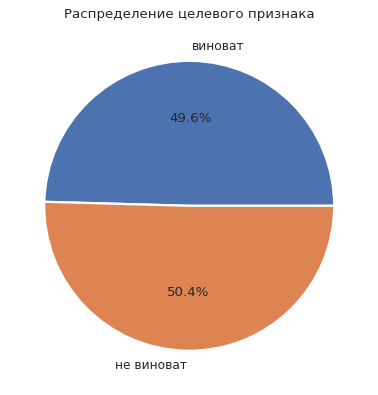

In [86]:
n1 = data_df[data_df['at_fault'] == 0]['at_fault'].count()
n2 = data_df[data_df['at_fault'] == 1]['at_fault'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['виноват', 'не виноват'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение целевого признака')
plt.show()

Дисбаланса классов нет.

Размер страховки - также является признаком, уже известным на момент начала движения автомобиля. Поэтому используем его для модели.

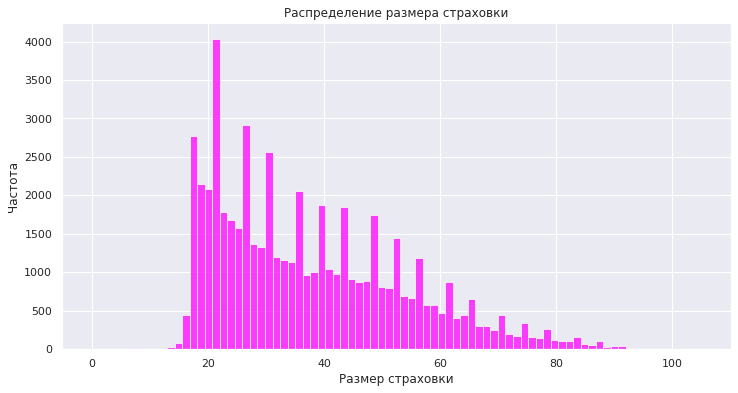

In [87]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_df, x="insurance_premium", color="magenta", label="Размер страховки")

plt.ylabel('Частота')
plt.xlabel('Размер страховки')
plt.title('Распределение размера страховки')
plt.show()

Размер страховки выглядит разумно, выбросов не видно. Видно, что есть какие-то конкретные суммы страховки, которые встречаются чаще.

Возьмем для модели также признак наличие телефона, так как это уже известно на момент поездки.

In [88]:
data_df['cellphone_in_use'].unique()

array([ 0., nan,  1.])

In [89]:
data_df['cellphone_in_use'] = data_df['cellphone_in_use'].fillna(0)

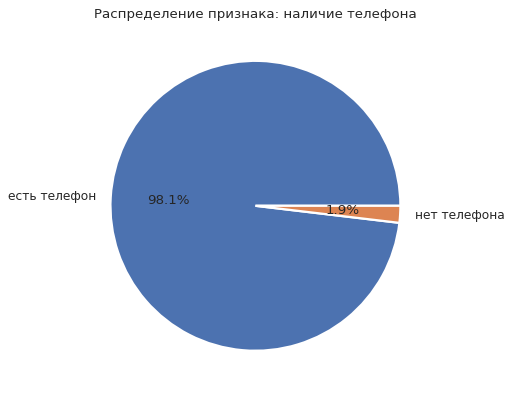

In [90]:
n1 = data_df[data_df['cellphone_in_use'] == 0]['at_fault'].count()
n2 = data_df[data_df['cellphone_in_use'] == 1]['at_fault'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2], labels=['есть телефон', 'нет телефона'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение признака: наличие телефона')
plt.show()

В большинстве автомобилей есть возможность разговаривать по телефону.

In [91]:
data_df['vehicle_type'].unique()

array(['sedan', 'coupe', 'other'], dtype=object)

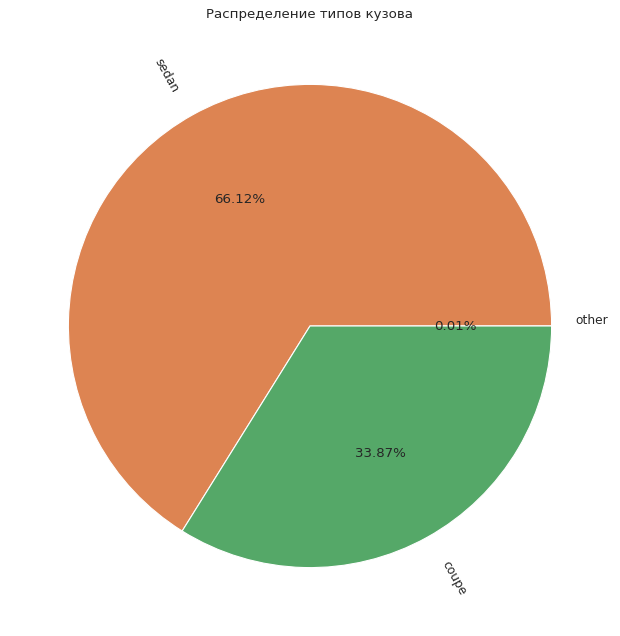

In [92]:
n1 = data_df[data_df['vehicle_type'] == 'other']['at_fault'].count()
n2 = data_df[data_df['vehicle_type'] == 'sedan']['at_fault'].count()
n3 = data_df[data_df['vehicle_type'] == 'coupe']['at_fault'].count()

plt.figure(figsize=(12,10), dpi= 80)
plt.pie([n1, n2, n3], labels=['other', 'sedan', 'coupe'], wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'}, autopct='%.2f%%', rotatelabels=True)
plt.title('Распределение типов кузова')
plt.show()

Также возьмем все признаки, касающиеся автомобиля (тип кузова, коробки передач и возраст). Эти признаки точно могут влиять на вероятность ДТП. Большинство автомобилей имеют тип кузова sedan.

In [93]:
data_df['vehicle_transmission'].unique()

array(['auto', 'manual', 'N'], dtype=object)

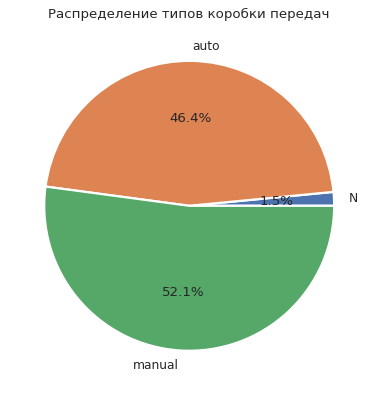

In [94]:
n1 = data_df[data_df['vehicle_transmission'] == 'N']['at_fault'].count()
n2 = data_df[data_df['vehicle_transmission'] == 'auto']['at_fault'].count()
n3 = data_df[data_df['vehicle_transmission'] == 'manual']['at_fault'].count()
plt.figure(figsize=(10,6), dpi= 80)
plt.pie([n1, n2, n3], labels=['N', 'auto', 'manual'], wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white'}, autopct='%.1f%%')
plt.title('Распределение типов коробки передач')
plt.show()

Примерно половина автомобилей имеет ручную коробку передач и половина - автоматическую.

Посмотрим на распределение возраста автомобилей. Как было показано выше, возраст автомобиля влияет на тяжесть повреждений. Скорее всего, он может влиять и на вероятность ДТП.

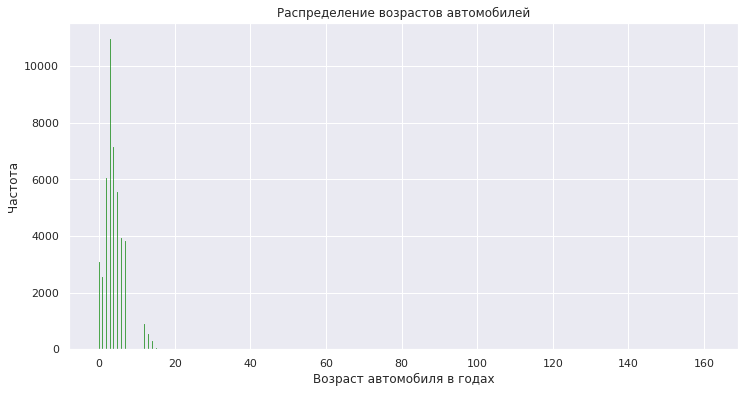

In [95]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_df, x="vehicle_age", color="green", label="Возраст автомобиля")

plt.ylabel('Частота')
plt.xlabel('Возраст автомобиля в годах')
plt.title('Распределение возрастов автомобилей')
plt.show()

In [96]:
temp = data_df.dropna()

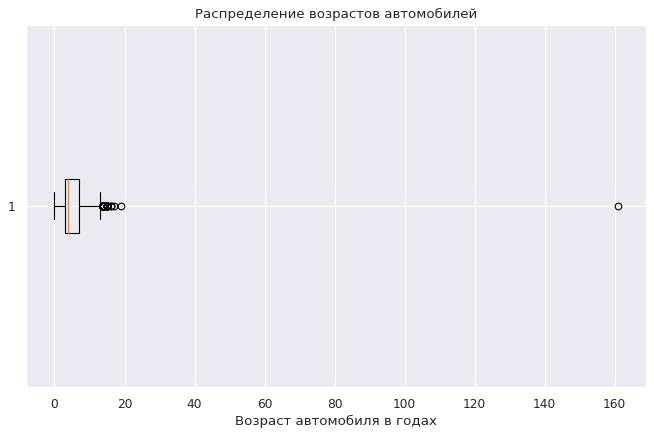

In [97]:
plt.figure(figsize=(10,6), dpi= 80)
plt.boxplot(temp['vehicle_age'], vert=False)
plt.title('Temperature_K')
plt.xlabel('Возраст автомобиля в годах')
plt.title('Распределение возрастов автомобилей')
plt.show()

Выбросим после разбиения на тренировочную и тестовую выборки все данные, относящиеся к автомобилям старше 10 лет, а заодно и  выброс 160 лет, так как каршеринги не используют старые автомобили, поскольку это экономически не выгодно.

Направление движения - сомнительный признак. Не уверена, что его стоит оставлять, так как направление может меняться в процессе движения. Решила оставить его, так как регион - Калифорния, где можно долго ехать по хайвею в одном направлении, например, вдоль океана.

In [98]:
data_df['direction'].unique()

array([None, 'east', 'west', 'north', 'south'], dtype=object)

In [99]:
data_df['direction'] = data_df['direction'].fillna('unknown')

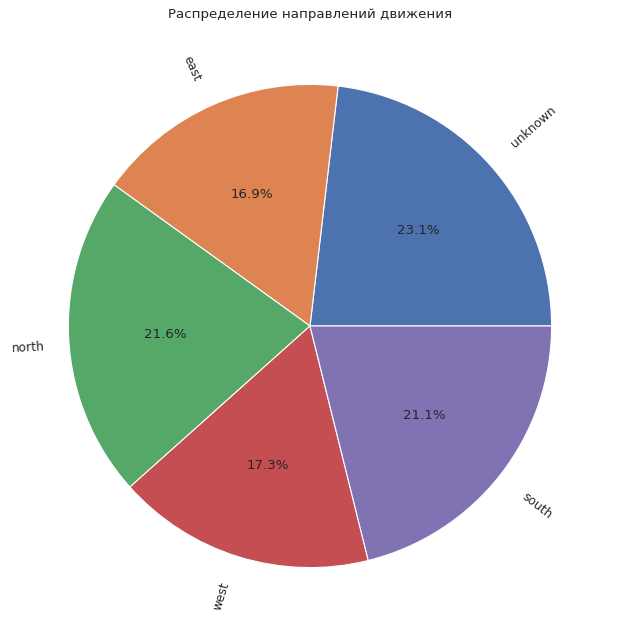

In [100]:
n1 = data_df[data_df['direction'] == 'unknown']['at_fault'].count()
n2 = data_df[data_df['direction'] == 'east']['at_fault'].count()
n3 = data_df[data_df['direction'] == 'north']['at_fault'].count()
n4 = data_df[data_df['direction'] == 'west']['at_fault'].count()
n5 = data_df[data_df['direction'] == 'south']['at_fault'].count()

#explode = (0, 0.15, 0, 0.25)
plt.figure(figsize=(12,10), dpi= 80)
plt.pie([n1, n2, n3, n4, n5], labels=['unknown', 'east', 'north', 'west', 'south'], wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'}, autopct='%.1f%%', rotatelabels=True)
plt.title('Распределение направлений движения')
plt.show()

Направления движения - примерно равновероятны.

In [101]:
data_df['road_condition_1'].unique()

array(['other', 'normal', 'loose material', 'construction', None,
       'reduced width', 'obstruction', 'holes', 'flooded'], dtype=object)

In [102]:
data_df['road_condition_1'] = data_df['road_condition_1'].fillna('other')

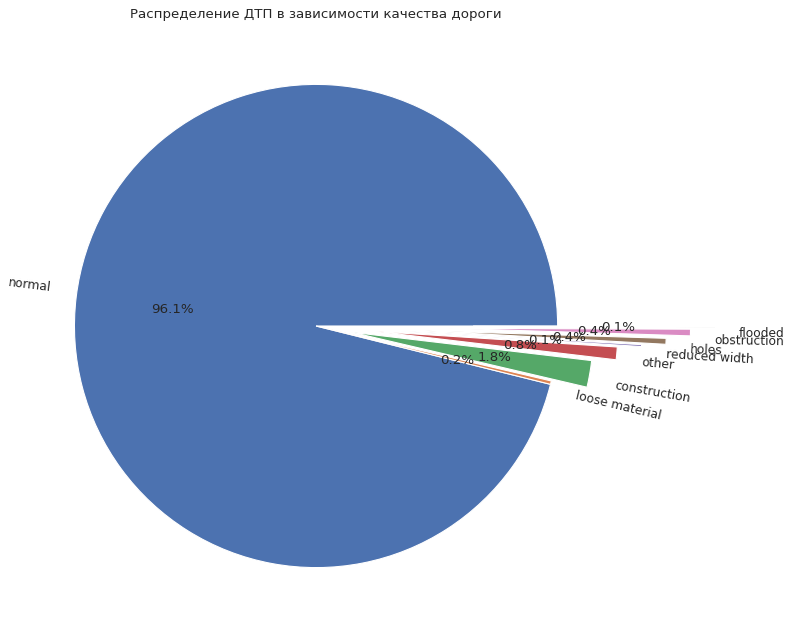

In [103]:
n1 = data_df[data_df['road_condition_1'] == 'normal']['at_fault'].count()
n2 = data_df[data_df['road_condition_1'] == 'loose material']['at_fault'].count()
n3 = data_df[data_df['road_condition_1'] == 'construction']['at_fault'].count()
n4 = data_df[data_df['road_condition_1'] == 'other']['at_fault'].count()
n5 = data_df[data_df['road_condition_1'] == 'reduced width']['at_fault'].count()
n6 = data_df[data_df['road_condition_1'] == 'holes']['at_fault'].count()
n7 = data_df[data_df['road_condition_1'] == 'obstruction']['at_fault'].count()
n8 = data_df[data_df['road_condition_1'] == 'flooded']['at_fault'].count()
explode = (0, 0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65)
plt.figure(figsize=(12,10), dpi= 80)
plt.pie([n1, n2, n3, n4, n5, n6, n7, n8], labels=['normal', 'loose material', 'construction', 'other', 'reduced width', 'holes', 'obstruction', 'flooded'], wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white'}, autopct='%.1f%%', rotatelabels=True, explode=explode)
plt.title('Распределение ДТП в зависимости качества дороги')
plt.show()

In [104]:
data_df['road_condition_1'].value_counts()

road_condition_1
normal            53964
construction       1001
other               476
obstruction         248
holes               222
loose material      128
reduced width        72
flooded              32
Name: count, dtype: int64

In [105]:
data_df = replace(data_df, 'road_condition_1')

In [106]:
data_df['road_condition_1'].value_counts()

road_condition_1
normal          53964
other            1178
construction     1001
Name: count, dtype: int64

В 96% случаев движение происходит по дороге нормального качества.

<a id='6'></a>
## Корреляционный анализ

Построим матрицу корреляций Phi_K.

У нас есть только два числовых признака:

In [107]:
num_col = ['insurance_premium', 'vehicle_age']

In [108]:
data_phik = data_df.phik_matrix(interval_cols = num_col)
display(data_phik)

,collision_date,weather_1,county_city_location,county_location,direction,at_fault,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,road_condition_1
collision_date,1.000000,0.099300,0.201047,0.041391,0.017581,0.027689,0.044722,0.009691,0.029545,0.000000,0.011808,0.015550
weather_1,0.099300,1.000000,0.389761,0.125643,0.037362,0.046913,0.023579,0.017911,0.078271,0.016855,0.000000,0.160307
county_city_location,0.201047,0.389761,1.000000,1.000000,0.424905,0.150653,0.163118,0.461409,0.263320,0.217150,0.106304,0.353617
county_location,0.041391,0.125643,1.000000,1.000000,0.114097,0.107911,0.056538,0.353514,0.140606,0.060301,0.000000,0.103325
direction,0.017581,0.037362,0.424905,0.114097,1.000000,0.049957,0.050783,0.015918,0.084527,0.045109,0.000000,0.055667
at_fault,0.027689,0.046913,0.150653,0.107911,0.049957,1.000000,0.250268,0.012290,0.097750,0.055575,0.000000,0.005771
insurance_premium,0.044722,0.023579,0.163118,0.056538,0.050783,0.250268,1.000000,0.001782,0.106514,0.082699,0.000000,0.006666
cellphone_in_use,0.009691,0.017911,0.461409,0.353514,0.015918,0.012290,0.001782,1.000000,0.000000,0.006161,0.000000,0.004439
vehicle_type,0.029545,0.078271,0.263320,0.140606,0.084527,0.097750,0.106514,0.000000,1.000000,0.325204,0.000000,0.044897
vehicle_transmission,0.000000,0.016855,0.217150,0.060301,0.045109,0.055575,0.082699,0.006161,0.325204,1.000000,0.046041,0.010177


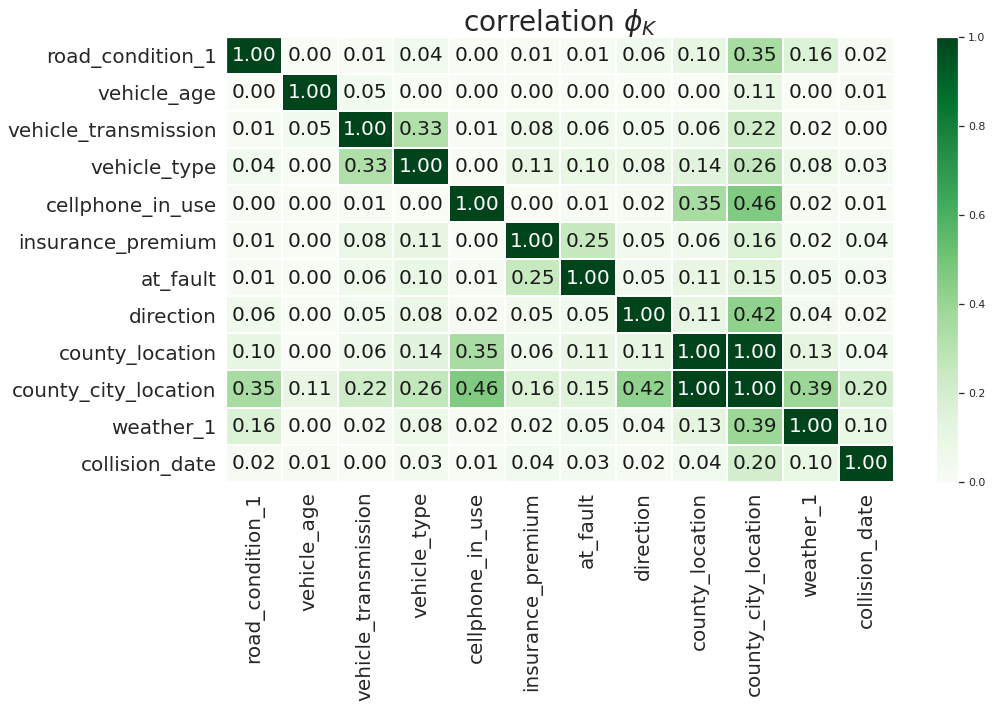

In [109]:
plot_correlation_matrix(data_phik.values, 
                        x_labels=data_phik.columns, 
                        y_labels=data_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=2, 
                        figsize=(15, 10))

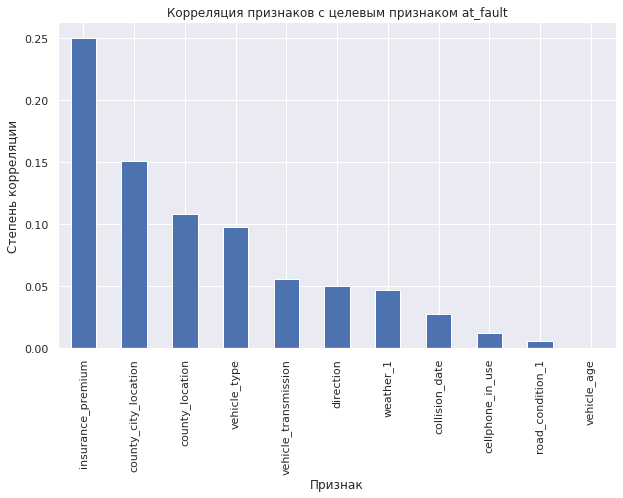

In [110]:
plt.figure(figsize=(10, 6))
_ = data_phik['at_fault'].sort_values(ascending=False)[1:].plot(kind='bar')

plt.ylabel('Степень корреляции')
plt.xlabel('Признак')
plt.title('Корреляция признаков с целевым признаком at_fault')
plt.show()

Корреляционный анализ показывает, что самыми важными (самая высокая степень корреляции с целевым признаком) являются сумма страховки, возраст автомобиля и местоположение. Причем признак county_city_location можно выкинуть, так как он имеет 100% корреляцию с county_location.

<a id='7'></a>
## Обучение модели

В нашем случае имеется задача бинарной классификации. Для оценки модели можно использовать следующие метрики: accuracy, которая дает долю правильно предсказанных случаев, precision, которая измеряет количество виновных, которые действительно виновны, recall, которая дает долю реально виновных, правильно предсказанных моделью и roc-auc, показывающая качество модели (способность модели различать класссы) и f1 - гармоническое среднее между точностью и полнотой. Если важно не пропустить виновных, то используется recall, если важно избежать ложных обвинений, то - precision.

Поскольку в наша задача - предсказать вероятность ДТП и виновность участника связана с этой вероятностью косвенно, то возьмем метрику roc-auc, которая показывает общее качество модели.

В нашем случае важно, чтобы модель качественно предсказывала оба класса, так, чтобы невиновные водители не подвергались необоснованному повышению стоимости поездки, но и виновные в аварии не были пропущены, и компания подстраховалась от возможных убытков.

В качестве моделей будем использовать DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и CatBoostClassifier.

Про ведем предварительное масштабирование численных признаков при помощи StandardScaler и кодирование категориальных при помощи OneHotEncoder. Подбор параметров будем проводить при помощи RandomizedSearchCV.

In [111]:
data_df = data_df.drop(['county_city_location'], axis=1)

Категориальные признаки:

In [112]:
cat_col =['collision_date', 'weather_1', 'county_location', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission', 'direction', 'road_condition_1']

In [113]:
Y = data_df['at_fault']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(columns=['at_fault']), 
    Y, 
    test_size=TEST_SIZE, 
    random_state = RANDOM_STATE)

In [115]:
indx = X_train.query('vehicle_age > 10').index

In [116]:
indx

Index([21082, 29322, 49989, 32270, 22803, 48965, 52443,  8256, 33994, 34272,
       ...
       44262, 42557, 33827, 42530, 52251,  2568, 40774, 11534,  6873, 35920],
      dtype='int64', length=2359)

In [117]:
X_train = X_train.drop(indx)
y_train = y_train.drop(indx)

In [118]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'num', 
            StandardScaler()
        )
    ]
)

In [119]:
# создаём пайплайн для подготовки признаков из списка cat_col: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [120]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('num', num_pipe, num_col)
    ], 
    remainder='passthrough'
)

In [121]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__depth': range(2, 8),
        'models__iterations': range(500, 1000),
        'models__learning_rate': np.arange(0.008, 0.05),
        #'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    #словарь для модели SVC()
    #{
        #'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        #'models__kernel': ['linear', 'rbf']
    #}
]

In [122]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=3,
    scoring='roc_auc',
    error_score='raise',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [123]:
randomized_search.fit(X_train, y_train)

0:	learn: 0.6924446	total: 52ms	remaining: 43.3s
1:	learn: 0.6918349	total: 56.9ms	remaining: 23.7s
2:	learn: 0.6911667	total: 60.9ms	remaining: 16.9s
3:	learn: 0.6905300	total: 64.9ms	remaining: 13.5s
4:	learn: 0.6898996	total: 69ms	remaining: 11.5s
5:	learn: 0.6892977	total: 73ms	remaining: 10.1s
6:	learn: 0.6887640	total: 77ms	remaining: 9.1s
7:	learn: 0.6881580	total: 81.1ms	remaining: 8.38s
8:	learn: 0.6875422	total: 85.3ms	remaining: 7.83s
9:	learn: 0.6869550	total: 89.6ms	remaining: 7.39s
10:	learn: 0.6863672	total: 94ms	remaining: 7.04s
11:	learn: 0.6857878	total: 98ms	remaining: 6.72s
12:	learn: 0.6852312	total: 102ms	remaining: 6.45s
13:	learn: 0.6847400	total: 106ms	remaining: 6.21s
14:	learn: 0.6842248	total: 110ms	remaining: 5.99s
15:	learn: 0.6836843	total: 113ms	remaining: 5.8s
16:	learn: 0.6831573	total: 117ms	remaining: 5.64s
17:	learn: 0.6826998	total: 121ms	remaining: 5.5s
18:	learn: 0.6821859	total: 125ms	remaining: 5.36s
19:	learn: 0.6817431	total: 129ms	remaining:

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['collision_date',
                                                                                'weather_1',
                                                                                'county_location',...
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 7)},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5)},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x7f589fbf7c10>],
                                         'models__depth': range(2, 8),
                                         'models__iterations': range(500, 1000),
                                         'models__learning_rate': array([0.008])}],
                   random_state=42, scoring='roc_auc')

In [124]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['collision_date',
                                                   'weather_1',
                                                   'county_location',
                                            

In [125]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_)

Лучшая модель и её параметры:

 {'models__learning_rate': 0.008, 'models__iterations': 644, 'models__depth': 6, 'models': <catboost.core.CatBoostClassifier object at 0x7f589fbf7c10>}


In [126]:
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Метрика лучшей модели на кросс-валидации: 0.6792044640498031


In [127]:
y_test_pred = randomized_search.predict_proba(X_test)

In [128]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.6724295794383414


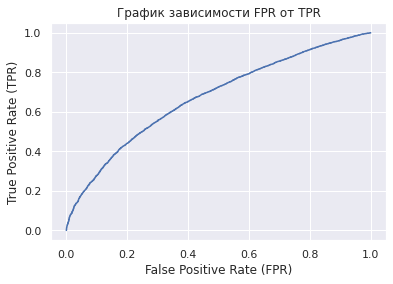

In [129]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred[:, 1], pos_label=1)
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

Качество модели получилось так себе. Кривая, конечно, лежит выше прямой у=х, то есть, модель лучше случайной.

In [130]:
best_model = randomized_search.best_estimator_

In [131]:
y_test_pred_v = best_model.predict(X_test)

Определим метрику accuracy, характеризующую общую точность модели, дающую долю правильных предсказаний. Метрика получилась довольно низкой.

In [132]:
acc = accuracy_score(y_test, y_test_pred_v)
print(acc)

0.6272442291251069


In [133]:
conf_matrix = confusion_matrix(y_test, y_test_pred_v)

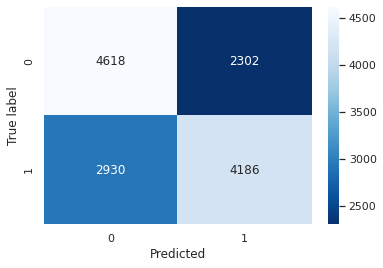

In [134]:
cm = confusion_matrix(y_test, y_test_pred_v)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Матрица ошибок, построенная на тестовых данных, показывает, что модель чаще совершает ошибки FN (ложноотрицательные), чем FP (ложноположительные).

In [135]:
recall = recall_score(y_test, y_test_pred_v, average="binary", pos_label=1)

In [136]:
precision = precision_score(y_test, y_test_pred_v, average="binary", pos_label=1)

In [137]:
print('recall: ',round(recall ,3))

recall:  0.588


In [138]:
print('precision: ',round(precision,3))

precision:  0.645


Метрика recall получилась ниже, чем метрика precision. То есть, больше внимания уделяется ошибкам первого рода (ошибки FP) и меньше - ошибкам второго рода (FN).

Если бы нашей задачей было бы предсказывать виновность, то самое главное было бы не поставить 0 (не виновен в аварии) там, где на самом деле 1 (виновен в аварии). Соответственно, самой худшей ситуацией будет, когда на самом деле водитель - виновник ДТП, а предсказание дает ответ, что нет (ложноотрицательный результат - FN). Прогнозы False Negative называют ошибками второго рода, и их надо было бы свести к минимуму. То есть, более важной была бы метрика recall, и именно ее надо максимизировать.

In [139]:
report = classification_report(y_test, y_test_pred_v, target_names=['Не виновен в ДТП', 'Виновен в ДТП'])
print(report)

                  precision    recall  f1-score   support

Не виновен в ДТП       0.61      0.67      0.64      6920
   Виновен в ДТП       0.65      0.59      0.62      7116

        accuracy                           0.63     14036
       macro avg       0.63      0.63      0.63     14036
    weighted avg       0.63      0.63      0.63     14036



Выше приведен отчет, который показывает ключевые метрики оценки качества модели классификации для каждого класса и всей модели в целом.

Для класса 0 значения метрик, в целом, получились выше, чем для класса 1 (f1 - гармоническое среднее между точностью и полнотой у класса 0 выше). Особенно низкой получилась полнота для класса 1 - 0.59, то есть, модель поймала чуть больше половины всех образцов этого класса. 

In [140]:
# Создайте dummy классификатор, который предсказывает наиболее частый класс
dummy_clf = DummyClassifier(strategy='most_frequent')

In [141]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [142]:
# Получите предсказания dummy модели
y_pred_dummy = dummy_clf.predict(X_test)

In [143]:
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

In [144]:
print(f'Точность dummy модели: {accuracy_dummy:.4f}')

Точность dummy модели: 0.5070


In [145]:
print(f'Точность нашей модели: {acc:.4f}')

Точность нашей модели: 0.6272


Наша модель оказалась всё-таки немного лучше случайной.

In [146]:
report_dummy = classification_report(y_test, y_pred_dummy, target_names=['Не виновен в ДТП', 'Виновен в ДТП'])
print(report_dummy)

                  precision    recall  f1-score   support

Не виновен в ДТП       0.00      0.00      0.00      6920
   Виновен в ДТП       0.51      1.00      0.67      7116

        accuracy                           0.51     14036
       macro avg       0.25      0.50      0.34     14036
    weighted avg       0.26      0.51      0.34     14036



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id='8'></a>
## Проведите анализ важности факторов ДТП

Проанализируем важность признаков для модели.

In [147]:
model = randomized_search.best_estimator_.named_steps['models']

In [148]:
prep = randomized_search.best_estimator_.named_steps['preprocessor']

In [149]:
X_train_pre = prep.transform(X_train)

In [150]:
col_names = prep.get_feature_names_out().tolist()

In [151]:
X_train_pre_df = pd.DataFrame(X_train_pre, columns=col_names)

In [152]:
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_pre_df.columns,
        'Importance': model.feature_importances_
    })

In [153]:
print(feature_importances.sort_values('Importance', ascending=False))

                                Feature  Importance
25              ohe__vehicle_type_sedan   30.372451
34               num__insurance_premium   26.248710
30               ohe__direction_unknown   13.550228
35                     num__vehicle_age    6.338011
27     ohe__vehicle_transmission_manual    3.233009
16           ohe__county_location_other    2.673131
26       ohe__vehicle_transmission_auto    2.391081
14     ohe__county_location_los angeles    2.277689
6                 ohe__weather_1_cloudy    2.258068
5                 ohe__collision_date_6    1.627523
9                ohe__weather_1_raining    1.541140
15          ohe__county_location_orange    0.903463
4                 ohe__collision_date_5    0.881084
29                 ohe__direction_south    0.605577
12          ohe__county_location_fresno    0.580934
3                 ohe__collision_date_4    0.531873
10               ohe__weather_1_snowing    0.493278
32         ohe__road_condition_1_normal    0.458040
28          

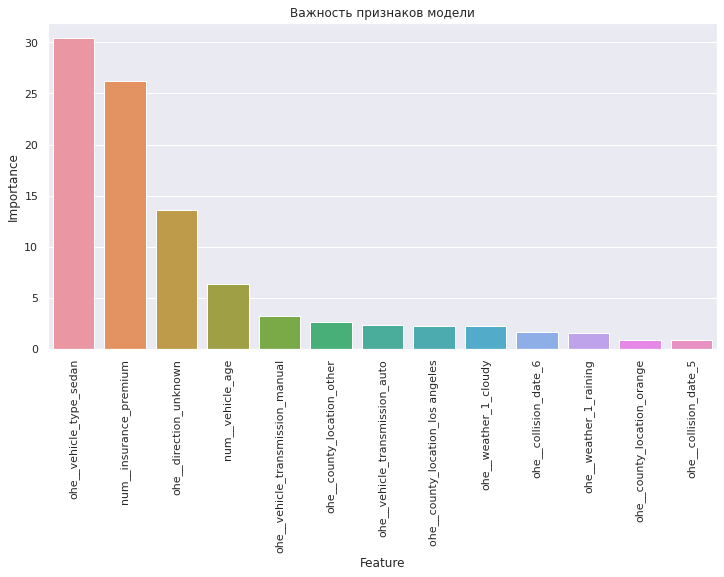

In [154]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=feature_importances.query('Importance > 0.7').sort_values('Importance', ascending=False), 
    x="Feature", 
    y="Importance", 
)
plt.xticks(rotation=90)
plt.title('Важность признаков модели');

Ожидаемо, самым важным признаком оказалась трезвость участника (Не пил и Был пьян, под влиянием), а также сумма страховки. Возможно этот признак косвенно содержит информацию о водителе. К сожалению, в представленных данных нет подробных данных о водителе, а именно они являются определяющими в предсказании вероятности ДТП.

В меньшей степени на модель повлияли признаки: возраст автомобиля, тип кузова и местоположение поездки.

In [155]:
train_df = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [156]:
train_df.head()

,collision_date,weather_1,county_location,direction,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,road_condition_1,at_fault
6757,3,cloudy,sacramento,north,40.0,1.0,sedan,auto,2.0,normal,1
37294,2,clear,orange,east,30.0,0.0,sedan,auto,4.0,normal,1
23180,2,clear,los angeles,north,34.0,0.0,sedan,manual,4.0,normal,1
21121,2,clear,other,west,34.0,0.0,sedan,auto,3.0,normal,1
39437,1,clear,los angeles,east,33.0,0.0,coupe,N,5.0,normal,0


In [157]:
col1 = 'insurance_premium'
col2 = 'at_fault'

In [158]:
insurance_df = train_df[[col1, col2]]

In [159]:
insurance_df.head()

,insurance_premium,at_fault
6757,40.0,1
37294,30.0,1
23180,34.0,1
21121,34.0,1
39437,33.0,0


In [160]:
def fill_fn(insurance_premium):
    if insurance_premium < 10:
        return 'low'
    if (insurance_premium >= 10 and insurance_premium < 30):
        return 'medium_low'
    if (insurance_premium >= 30 and insurance_premium < 60):
        return'medium_high'
    if insurance_premium >= 60:
        return 'high'

In [161]:
insurance_df['ins_category'] = insurance_df['insurance_premium'].apply(fill_fn)

In [162]:
insurance_df.head()

,insurance_premium,at_fault,ins_category
6757,40.0,1,medium_high
37294,30.0,1,medium_high
23180,34.0,1,medium_high
21121,34.0,1,medium_high
39437,33.0,0,medium_high


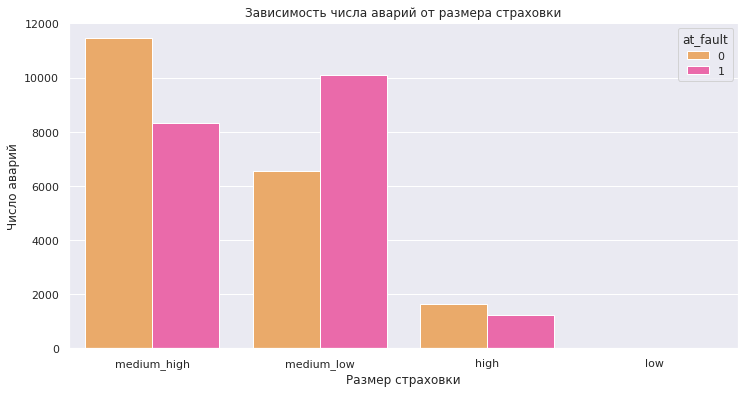

In [163]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.countplot(
    data=insurance_df, 
    x="ins_category",
    palette='spring_r',
    hue = 'at_fault'
)
plt.ylabel('Число аварий')
plt.xlabel('Размер страховки')
plt.title('Зависимость числа аварий от размера страховки') 
plt.show();

Из графика видно, что больше всего виновных среди владельцев средне-низкой страховки (от 10 до 30 тыс. долларов). Владельцы средне-высокой страховки чаще невиновны (от 30 до 60 тыс. долларов), а владельцы дорогой страховки могут быть и виновны и невиновны примерно поровну (больше 60 тыс. долларов).

На мой взгляд, странная зависимость. Мне казалось, что высокая страховка должна быть у неблагонадежных водителей и, соответственно, большинство владельцев дорогой страховки должны быть виновны. Но получилось не так.

In [164]:
col_names = prep.get_feature_names_out().tolist()

In [165]:
X_train_pre = prep.transform(X_train.sample(n=500))

In [166]:
data_pool = Pool(X_train_pre)

In [167]:
X_train_pre_df = pd.DataFrame(X_train_pre, columns=col_names)

In [168]:
X_train_pre_df.head()

,ohe__collision_date_1,ohe__collision_date_2,ohe__collision_date_3,ohe__collision_date_4,ohe__collision_date_5,ohe__collision_date_6,ohe__weather_1_cloudy,ohe__weather_1_fog,ohe__weather_1_other,ohe__weather_1_raining,ohe__weather_1_snowing,ohe__weather_1_wind,ohe__county_location_fresno,ohe__county_location_kern,ohe__county_location_los angeles,ohe__county_location_orange,ohe__county_location_other,ohe__county_location_riverside,ohe__county_location_sacramento,ohe__county_location_san bernardino,ohe__county_location_san diego,ohe__county_location_santa clara,ohe__county_location_ventura,ohe__cellphone_in_use_1.0,ohe__vehicle_type_other,ohe__vehicle_type_sedan,ohe__vehicle_transmission_auto,ohe__vehicle_transmission_manual,ohe__direction_north,ohe__direction_south,ohe__direction_unknown,ohe__direction_west,ohe__road_condition_1_normal,ohe__road_condition_1_other,num__insurance_premium,num__vehicle_age
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.069412,-0.919901
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.097483,0.241212
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.180212,-1.306939
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.069412,1.402326
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.902495,2.176402


In [169]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,25,30.372451
1,34,26.248710
2,30,13.550228
3,35,6.338011
4,27,3.233009
5,16,2.673131
6,26,2.391081
7,14,2.277689
8,6,2.258068
9,5,1.627523


In [170]:
shap_values = model.get_feature_importance(data_pool, type="ShapValues")

In [171]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(500, 36)


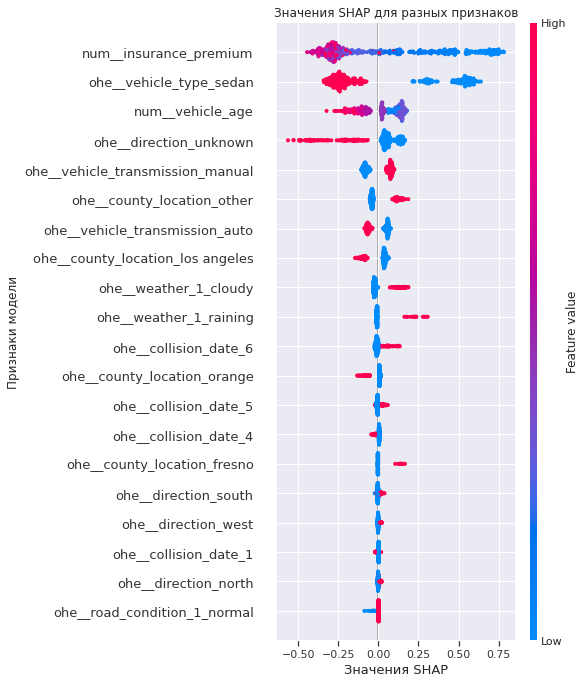

In [172]:
shap.summary_plot(shap_values, X_train_pre_df, show=False)

plt.xlabel('Значения SHAP')
plt.ylabel('Признаки модели')
plt.title('Значения SHAP для разных признаков') 
plt.show();

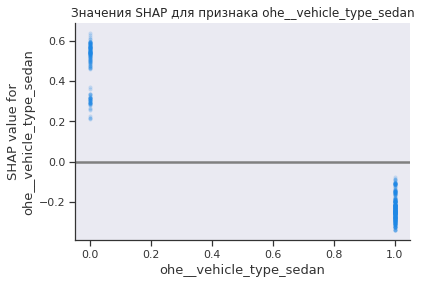

In [173]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('ohe__vehicle_type_sedan', shap_values, X_train_pre_df, interaction_index=None, alpha=0.2, ax=ax, show=False)

plt.title('Значения SHAP для признака ohe__vehicle_type_sedan') 
plt.show();

Анализ важности признаков показывает, что самый важный признак для модели ohe__vehicle_type_sedan. Значение 0 (то есть, машина не седан) этого параметра склоняют модель к тому, чтобы отнести объекты к классу 1 (то есть, виновен). По-моему, это связано с тем, что седан - наиболее распространенный тип кузова.

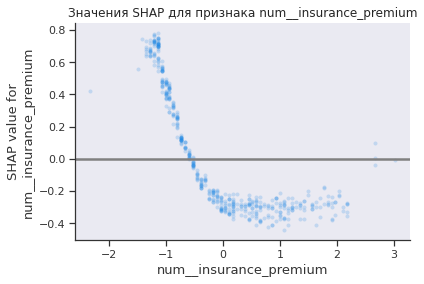

In [174]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__insurance_premium', shap_values, X_train_pre_df, interaction_index=None, alpha=0.2, ax=ax, show=False)

plt.title('Значения SHAP для признака num__insurance_premium') 
plt.show();

Следующий по важности признак num__insurance_premium. Чем выше сумма страховки, тем с большей вероятностью модель склоняется к классу 0 (не виновен). И только для самых больших сумм shap value опять начинает расти, то есть модель склоняется к 1 (виновен). Вообще непонятно. Казалось бы, страховку неблагонадежным водителям обычно повышают. Но, в принципе, похоже на анализ этого признака, сделанный выше.

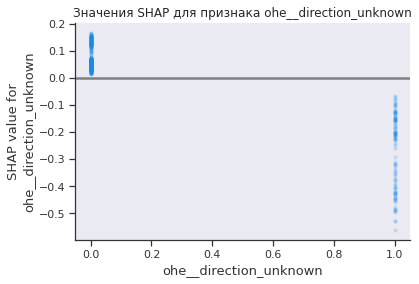

In [175]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('ohe__direction_unknown', shap_values, X_train_pre_df, interaction_index=None, alpha=0.2, ax=ax, show=False)

plt.title('Значения SHAP для признака ohe__direction_unknown') 
plt.show();

Если направление движения не было известно, то модель склоняется к классу 0 (не виновен). Не очень понятно.

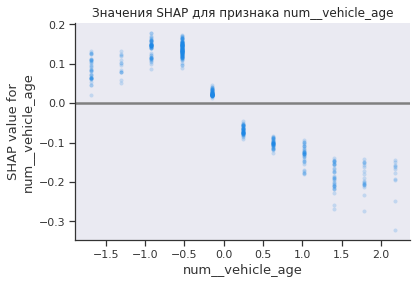

In [176]:
fig, ax = plt.subplots();
ax.grid();
plt.axhline(y=0, color='grey', linewidth=2.5);
shap.dependence_plot('num__vehicle_age', shap_values, X_train_pre_df, interaction_index=None, alpha=0.2, ax=ax, show=False)

plt.title('Значения SHAP для признака num__vehicle_age') 
plt.show();

Чем ниже значение признака num__vehicle_age (автомобиль новее), тем с большей вероятностью модель склоняется к классу 1 (виновен). 

**С возрастом автомобиля получается ерунда. Может, это связано с тем, что на этих графиках я их вижу в масштабированном виде или малый размер выборки?** 

<a id='9'></a>
## Выводы

Для создания модели нам даны три таблицы с информацией об авариях, участниках аварии и автомобилях. Согласно техническому заданию, необходимо оценить риск ДТП по выбранному маршруту движения. В качестве целевой переменной предлагается использоваать переменную, принимающую два значения: виновен (1) или не виновен (0) водитель в ДТП. То есть, предсказание целевой переменной, конечно, косвенно связано с риском ДТП, однако в реальности мы будем предсказывать только вероятность виновности или не виновности в ДТП.

Анализ доступных нам параметров показывает, что большинство из них не годятся для создания модели, так как они становятся известными только после того, как авария произошла. Явно не хватает данных о водителе: возраст, пол, стаж вождения и т.д. Возможно, косвенно эта информация входит в параметр Сумма страховки. К сожалению, подробностей в техническом задании нет.

Общий ключ для связи таблиц имеется: это case_id.

Статистический анализ факторов ДТП показал следующее:

Из запроса количества ДТП по месяцам видно, что в таблице collisions присутствуют данные с 2009 по 2013 гг., а также несколько записей для 2020 года. Видно, что данные по месяцам неполные.
Была сделана группировка по месяцу ДТП и построено распределение числа аварий от номера месяца. Использовались только те годы, где данные полные.
Показано, что самое большое число аварий происходит в октябре. Затем следует март и декабрь.


В техническом задании поставлена следующая задача. «Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам.»

**Задача №1.**
**Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП. Выберите тип виновника — только машина (car). Возьмите данные только за 2012 год.**

Сосчитаем относительное число каждого вида повреждений для каждого состояния дороги. Учтем то обстоятельство, что для каждого состояния дороги может быть собрано разное количество данных. Так, для заснеженной дороги в Калифорнии, скорее всего, будет очень мало строк в таблице, а для сухой дороги - много.
Вероятность получения повреждений уменьшается следующим образом: легкие повреждения (максимум), царапины, средние повреждения и серьезные повреждения. Средние повреждения можно получить практически с одинаковой вероятностью на любой дороге, серьезные повреждения  - на скользкой дороге, царапины - на влажной и сухой дороге, а легкие повреждения - почему-то на заснеженной.

**Задача №2.**
**Найдите самый частый тип участника ДТП (таблица parties).**

Больше всего данных представлено для типа участника проишествия - машина (car).

**Задача №3.**
**Определите, как зависит степень повреждения от среднего возраста автомобиля. Выберите тип виновника — только машина (car).**

Из гистограммы видно, что степень повреждения связана с возрастом автомобиля. Самые серьезные повреждения происходят с более возрастными автомобилями.

**Задача №4**
**Определите, как зависит степень проишесвия от числа участников.**

**Задача №5**
**Соотнесите время ДТП со следующими категориями: утро (с 6 до 12), день (с 13 до 17), вечер (с 18 до 22), ночь (с 23 до 5). Определите, как зависит число ДТП и степень повреждения автомобиля от времени суток.**

**Задача №6**
**Соотнесите время ДТП со следующими категориями: утро (с 6 до 12), день (с 13 до 17), вечер (с 18 до 22), ночь (с 23 до 5). Определите, как зависит трезвость участника от времени суток.**



**Для модели берем следующие признаки:**

COLLISION_DATE берем только день недели, хотя месяц был бы лучше. Но данные за 2012 год неполные по месяцам.

WEATHER_1, ROAD_SURFACE скорее всего сильно не поменяется за время поездки.

COUNTY_CITY_LOCATION, COUNTY_LOCATION, DIRECTION относятся к местоположению и общему направлению движения. Могут поменяться, но с меньшей вероятностью, чем другие признаки.

road_condition_1 Тоже может поменяться, но с меньшей вероятностью, особенно в Калифорнии.

AT_FAULT – целевой признак.

INSURANCE_PREMIUM, CELLPHONE_IN_USE, VEHICLE_TYPE, VEHICLE_TRANSMISSION, VEHICLE_AGE известно в начале поездки.


**Не берем:**

COLLISION_TIME так как это время аварии. Выехать можно утром, а попасть в аварию вечером.

INTERSECTION заранее не знаем, где произойдет авария.
COLLISION_DAMAGE, PRIMARY_COLL_FACTOR, DISTANCE, LOCATION_TYPE, PARTY_COUNT, PCF_VIOLATION_CATEGORY, TYPE_OF_COLLISION, MOTOR_VEHICLE_INVOLVED_WITH, PARTY_NUMBER, PARTY_TYPE заранее не известно.

LIGHTING может поменяться за поездку (днем одно освещение, вечером – другое).

PARTY_SOBRIETY для этого признака оборудование уже разработано и стоит копейки по сравнению с ущербом ДТП. В будущем обязательно учитываем.

PARTY_DRUG_PHYSICAL пока нет оборудования, но в будущем обязательно берем.

**Исследовательский анализ данных, выбранных для модели, показал следующее:**

Больше всего ДТП происходит в субботу и пятницу.

Больше всего данных о ДТП приведено для ясной, облачной и дождливой погоды.

Целевой признак at_fault распределяется примерно пополам, то есть дисбаланса классов нет.

Размер страховки выглядит разумно, выбросов не видно. Видно, что есть какие-то конкретные суммы страховки, которые встречаются чаще.

В большинстве автомобилей есть возможность разговаривать по телефону.

Большинство автомобилей имеют тип кузова sedan.

Примерно половина автомобилей имеет ручную коробку передач и половина - автоматическую.

Все данные, относящиеся к автомобилям старше 10 лет, были выброшены, так как каршеринги не используют старые автомобили, поскольку это экономически не выгодно.

Направления движения - примерно равновероятны.


В 96% случаев движение происходит по дороге нормального качества.

Корреляционный анализ (построена матрица phik) показывает, что самыми важными (самая высокая степень корреляции с целевым признаком) являются сумма страховки, возраст автомобиля и местоположение. Причем признак county_city_location можно выкинуть, так как он имеет 100% корреляцию с county_location.

**Обучение модели.**

В нашем случае имеется задача бинарной классификации. Для оценки модели можно использовать следующие метрики: accuracy, которая дает долю правильно предсказанных случаев, precision, которая измеряет количество виновных, которые действительно виновны, recall, которая дает долю реально виновных, правильно предсказанных моделью и roc-auc, показывающая качество модели (способность модели различать класссы). Если важно не пропустить виновных, то используется recall, если важно избежать ложных обвинений, то - precision.

Поскольку в наша задача - предсказать вероятность ДТП и виновность участника связана с этой вероятностью косвенно, то возьмем метрику roc-auc, которая показывает общее качество модели.
В нашем случае важно, чтобы модель качественно предсказывала оба класса, так, чтобы невиновные водители не подвергались необоснованному повышению стоимости поездки, но и виновные в аварии не были пропущены, и компания подстраховалась от возможных убытков.
В качестве моделей будем использовать DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и CatBoostClassifier.

Про ведем предварительное масштабирование численных признаков при помощи StandardScaler и кодирование категориальных при помощи OneHotEncoder. Подбор параметров будем проводить при помощи RandomizedSearchCV.

Лучшая модель и её параметры:
'models__learning_rate': 0.008, 'models__iterations': 644, 'models__depth': 6, 'models': catboost.core.CatBoostClassifier

Метрика лучшей модели на кросс-валидации: 0.68
Метрика ROC-AUC на тестовой выборке: 0.67
Матрица ошибок, построенная на тестовых данных, показывает, что модель чаще совершает ошибки FN (ложноотрицательные), чем FP (ложноположительные).

Отчет, который показывает ключевые метрики оценки качества модели классификации для каждого класса и всей модели в целом:
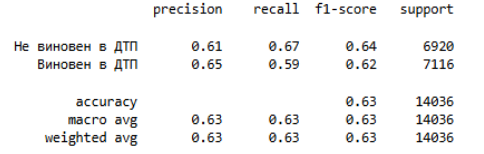
 
Для класса 0 значения метрик, в целом, получились выше, чем для класса 1 (f1 - гармоническое среднее между точностью и полнотой у класса 0 выше). Особенно низкой получилась полнота для класса 1 - 0.59, то есть, модель поймала чуть больше половины всех образцов этого класса.


**Проанализируем важность признаков для модели.**

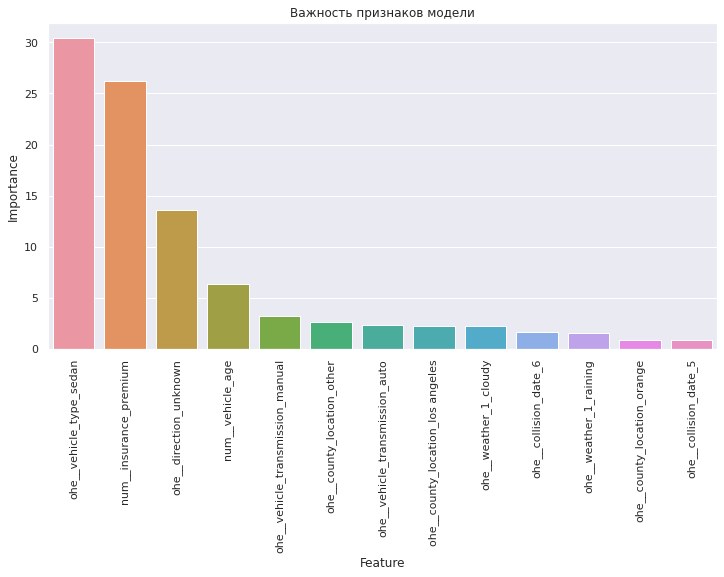
 
Самым важным признаком оказался признак сумма страховки. Возможно этот признак косвенно содержит информацию о водителе. К сожалению, в представленных данных нет подробных данных о водителе, а именно они являются определяющими в предсказании вероятности ДТП.
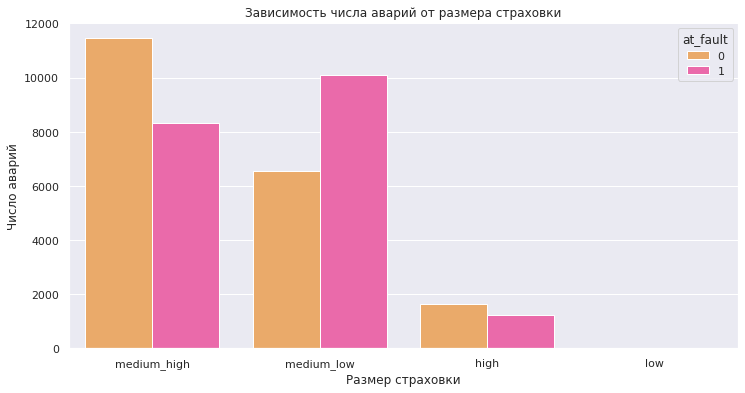

В меньшей степени на модель повлияли признаки: возраст автомобиля, тип кузова и местоположение поездки.

Анализ важности признаков показал высокую значимость признака Сумма страховки. Анализ связи этого признака с целевым, показал наличие связей между этими признаками, хотя эта связь оказалась не линейной, как я ожидала.

Сумма страховки, скорее всего, связана с характеристиками водителя. То есть, для улучшения модели требуется увеличить количество признаков относящихся к водителю, таких как стаж вождения, пол, предыдущие нарушения.

Возможно, что автомобиль следовало бы оснастить системой, способной получать данные о водителе по номеру его водительского удостоверения.

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
<font size="3"><b></b></font>
Таким образом, проанализировав предоставленные данные и результаты работы модели, предсказывающей виновность водителя, можно сделать вывод о том, что на основании имеющихся данных не получилось сделать модель, позволяющую с высокой вероятностью разделять классы.
    
Налицо недостаток таких данных о водителе как возраст, пол, стаж вождения, число и тяжесть аварий, в которых он был виновником.
Однозначно все автомобили (не только каршеринг) должны быть оборудованы устройством, определяющим трезвость водителя. Да и из общих соображений известно, что неадекватное состояние водителя является одним из определяющих факторов, приводящих к ДТП. Стоимость вполне качественных алкотестеров несопоставима с ущербом от ДТП.
    
В базе данных parties был еще один важный признак, характеризующий состояние водителя - PARTY_DRUG_PHYSICAL. Думаю, что в ближайшем будущем его тоже надо будет учитывать. Во-первых, машина может быть оборудована камерой с возможностью анализировать изображение. 
Во-вторых, есть ряд простых и недолгих тестов позволяющих оценивать скорость реакции водителя. Поскольку и без модели понятно, что состояние водителя – основной признак, определяющий вероятность ДТП и виновность в ДТП.
</div>